In [40]:
import os
os.chdir('../..')

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import mplhep as hep

from coffea.util import load
from coffea.hist import plot
import numpy as np
import pandas as pd

from pprint import pprint 
hep.style.use(hep.style.ROOT)

import torch
from torch import nn
from torch import optim

from math import floor

In [2]:
filename1 = "/work/dvalsecc/ttHbb/PocketCoffea/output/parton_matching_dR02_v07/output.coffea" 
output = load(filename1)
output.keys()

dict_keys(['sum_genweights', 'cutflow', 'sumw', 'seed_chunk', 'hist_muon_pt', 'hist_muon_eta', 'hist_muon_phi', 'hist_electron_pt', 'hist_electron_eta', 'hist_electron_phi', 'hist_jet_pt', 'hist_jet_eta', 'hist_jet_phi', 'hist_nmuon', 'hist_nelectron', 'hist_nlep', 'hist_njet', 'hist_nbjet', 'hist_nparton', 'hist_parton_pt', 'hist_parton_eta', 'hist_parton_phi', 'hist_parton_pdgId', 'hist_npartonmatched', 'hist_partonmatched_pt', 'hist_partonmatched_eta', 'hist_partonmatched_pdgId', 'hist2d_Njet_Nparton_total', 'hist2d_Njet_Nparton_matched', 'hist2d_Nparton_Nparton_matched', 'columns', 'hist_ptComparison_parton_matching', 'hist_deltaR_parton_matching', 'scale_genweight'])

In [3]:
df_sig = pd.DataFrame({k: v['ttHTobb'].value for k, v in output["columns"]['4j'].items()  if k != "njet_matched"})
df_tt = pd.DataFrame({k: v['TTToSemiLeptonic'].value for k, v in output["columns"]['4j'].items()  if k != "njet_matched"})

In [53]:
df_tt

,parton_pt,parton_pdgId,jet_pt,jet_eta,parton_jet_dR,jet_btag
0,105.714844,-5,115.25000,-0.895752,0.008585,0.994141
1,73.570312,-3,76.06250,-1.239746,0.027835,0.365479
2,79.425781,5,55.53125,-2.316895,0.011793,0.500000
3,32.792969,4,30.96875,-0.815552,0.060229,0.006954
4,75.742188,-5,77.68750,0.595459,0.143543,0.968750
...,...,...,...,...,...,...
12768401,71.542969,-5,61.53125,-1.698242,0.139919,0.995605
12768402,78.960938,-4,59.00000,-0.246582,0.034607,0.505859
12768403,61.708984,21,48.34375,-1.428223,0.152525,0.005764
12768404,98.539062,-2,100.12500,-1.656006,0.059142,0.001717


In [4]:
inputs_pts = df_tt[["parton_pt", "jet_pt"]].values

/tmp/ipykernel_11572/3380686233.py:4: UserWarning: Log scale: values of z <= 0 have been masked
  plt.contour(count, levels=30, extent=[xbins.min(),xbins.max(),ybins.min(),ybins.max()],linewidths=3, norm=LogNorm())


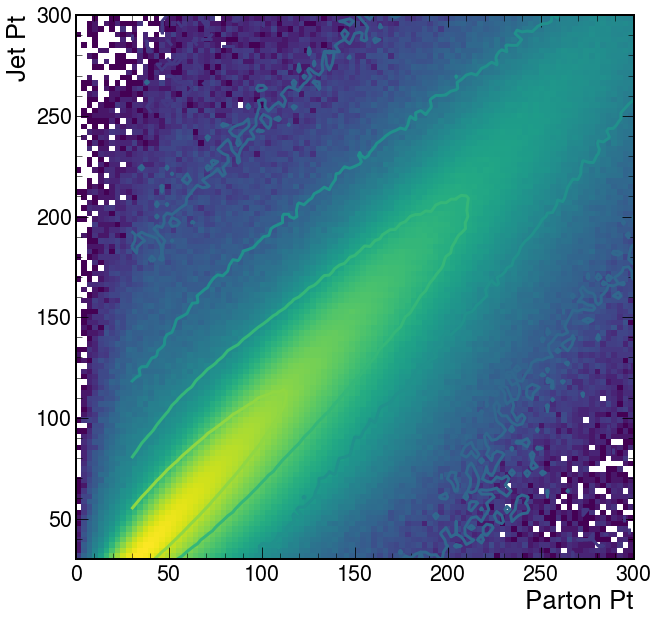

In [114]:
count, ybins,xbins, im = plt.hist2d(inputs_pts[:,0],inputs_pts[:,1], bins=100, range=((0,300),(30, 300) ), norm=LogNorm())
plt.ylabel("Jet Pt")
plt.xlabel("Parton Pt")
plt.contour(count, levels=30, extent=[xbins.min(),xbins.max(),ybins.min(),ybins.max()],linewidths=3, norm=LogNorm())
#plt.colorbar()

In [99]:
from nflows import transforms, distributions, flows

# Define an invertible transformation.
transform = transforms.CompositeTransform([
    transforms.MaskedAffineAutoregressiveTransform(features=2, hidden_features=10),
    transforms.RandomPermutation(features=2),
    transforms.MaskedAffineAutoregressiveTransform(features=2, hidden_features=10),
    transforms.RandomPermutation(features=2),
])

# Define a base distribution.
base_distribution = distributions.StandardNormal(shape=[2])


# Combine into a flow.
flow = flows.Flow(transform=transform, distribution=base_distribution)

optimizer = optim.Adam(flow.parameters())

In [95]:
flow

Flow(
  (_transform): CompositeTransform(
    (_transforms): ModuleList(
      (0): MaskedAffineAutoregressiveTransform(
        (autoregressive_net): MADE(
          (initial_layer): MaskedLinear(in_features=2, out_features=10, bias=True)
          (blocks): ModuleList(
            (0): MaskedResidualBlock(
              (linear_layers): ModuleList(
                (0): MaskedLinear(in_features=10, out_features=10, bias=True)
                (1): MaskedLinear(in_features=10, out_features=10, bias=True)
              )
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (1): MaskedResidualBlock(
              (linear_layers): ModuleList(
                (0): MaskedLinear(in_features=10, out_features=10, bias=True)
                (1): MaskedLinear(in_features=10, out_features=10, bias=True)
              )
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (final_layer): MaskedLinear(in_features=10, out_features=4, bi

In [83]:
samples = flow.sample(10000).detach().numpy()

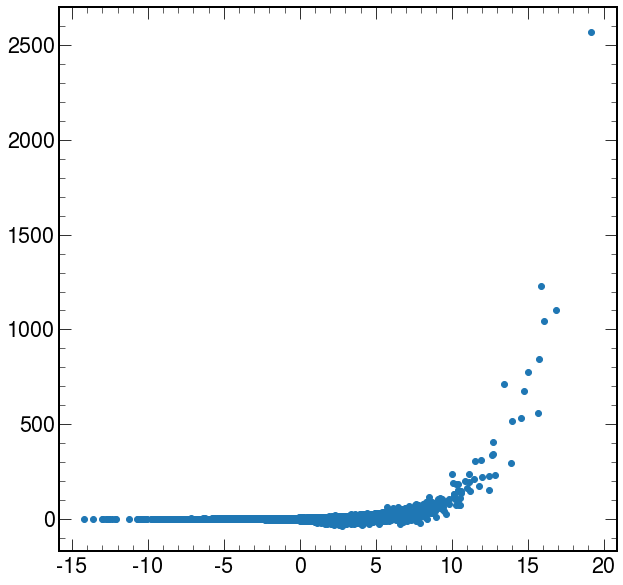

In [84]:
plt.scatter(samples[:,0], samples[:,1])

In [85]:
def plot_density(flow, title="", xrange=[-5,5], yrange=[-5,5]):
    plt.figure(figsize=(4,4))
    xline = torch.linspace(*xrange, 100)
    yline = torch.linspace(*yrange, 100)
    xgrid, ygrid = torch.meshgrid(xline, yline)
    xyinput = torch.cat([xgrid.reshape(-1, 1), ygrid.reshape(-1, 1)], dim=1)

    with torch.no_grad():
        zgrid = flow.log_prob(xyinput).exp().reshape(100, 100)

    plt.contourf(xgrid.numpy(), ygrid.numpy(), zgrid.numpy(), 20, cmap="Blues")
    plt.title(title)
    plt.show()

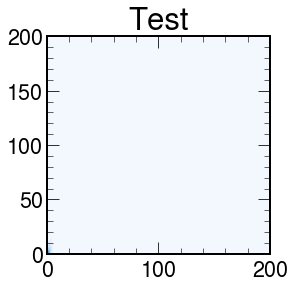

In [88]:
plot_density(flow, "Test", [0,200], [0,200])

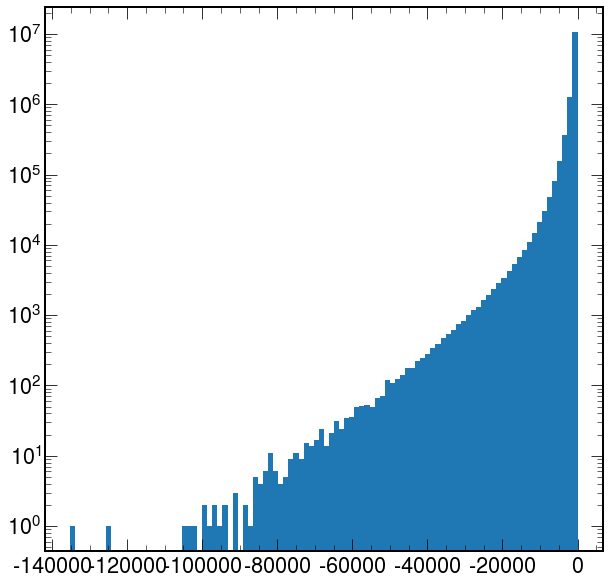

In [89]:
prob = flow.log_prob(inputs_pts).detach().numpy()
plt.hist(prob, bins=100)
plt.yscale("log")

# Training

	Step: 0, loss: 1640.63232421875
	Step: 1000, loss: 10.485044479370117
	Step: 2000, loss: 9.445531845092773
	Step: 3000, loss: 9.433931350708008
	Step: 4000, loss: 9.515213012695312
	Step: 5000, loss: 9.567752838134766
	Step: 6000, loss: 9.542463302612305
Epoch 0: loss: 13.232680320739746


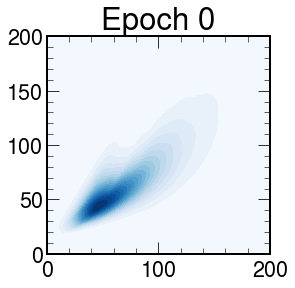

	Step: 0, loss: 9.552635192871094
	Step: 1000, loss: 9.475970268249512
	Step: 2000, loss: 9.37388801574707
	Step: 3000, loss: 9.541272163391113
	Step: 4000, loss: 9.391683578491211
	Step: 5000, loss: 9.435452461242676
	Step: 6000, loss: 9.41988468170166
Epoch 1: loss: 9.439432144165039


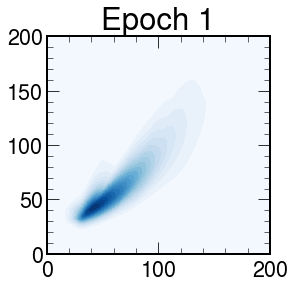

	Step: 0, loss: 9.414451599121094
	Step: 1000, loss: 9.535905838012695
	Step: 2000, loss: 9.5040922164917
	Step: 3000, loss: 9.329055786132812
	Step: 4000, loss: 9.316673278808594
	Step: 5000, loss: 9.385547637939453
	Step: 6000, loss: 9.396090507507324
Epoch 2: loss: 9.430712699890137


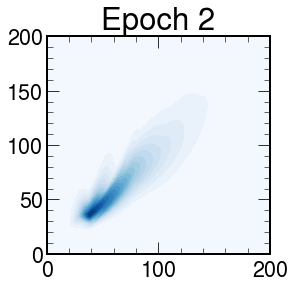

	Step: 0, loss: 9.421235084533691
	Step: 1000, loss: 9.375354766845703
	Step: 2000, loss: 9.345748901367188
	Step: 3000, loss: 9.36726188659668
	Step: 4000, loss: 9.393922805786133
	Step: 5000, loss: 9.379499435424805
	Step: 6000, loss: 9.344473838806152
Epoch 3: loss: 9.384325981140137


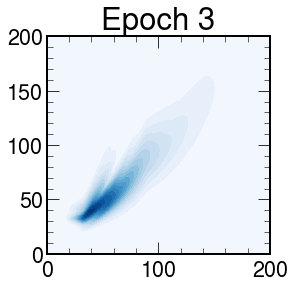

	Step: 0, loss: 9.29010009765625
	Step: 1000, loss: 9.278146743774414
	Step: 2000, loss: 9.346528053283691
	Step: 3000, loss: 9.302560806274414
	Step: 4000, loss: 9.445467948913574
	Step: 5000, loss: 9.424095153808594
	Step: 6000, loss: 9.347105979919434
Epoch 4: loss: 9.365001678466797


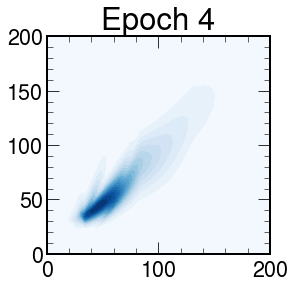

	Step: 0, loss: 9.427362442016602
	Step: 1000, loss: 9.416622161865234
	Step: 2000, loss: 9.352252960205078
	Step: 3000, loss: 9.353643417358398
	Step: 4000, loss: 9.33970832824707
	Step: 5000, loss: 9.373985290527344
	Step: 6000, loss: 9.420706748962402
Epoch 5: loss: 9.369769096374512


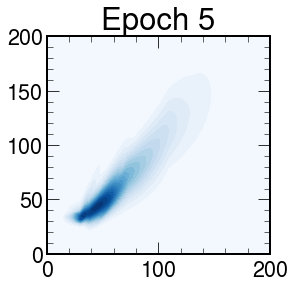

	Step: 0, loss: 9.529317855834961
	Step: 1000, loss: 9.330318450927734
	Step: 2000, loss: 9.349920272827148
	Step: 3000, loss: 9.36456298828125
	Step: 4000, loss: 9.426819801330566
	Step: 5000, loss: 9.255327224731445
	Step: 6000, loss: 9.356278419494629
Epoch 6: loss: 9.336556434631348


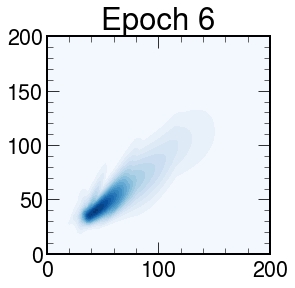

	Step: 0, loss: 9.501239776611328


KeyboardInterrupt: 

In [100]:
n_epochs = 10 # or whatever
batch_size = 2048 # or whatever
X = torch.tensor(inputs_pts, dtype=torch.float32)


for epoch in range(n_epochs):
    # X is a torch Variable
    permutation = torch.randperm(X.size()[0])
    
    losses_epoch = 0.
    nsteps = floor(X.size()[0]/ batch_size)
    for i in range(0,nsteps):
        optimizer.zero_grad()

        indices = permutation[i:i+batch_size]
        batch_x = X[indices]

        # in case you wanted a semi-full example
        
        optimizer.zero_grad()
        loss = -flow.log_prob(inputs=batch_x).mean()
        loss.backward()
        optimizer.step()
        losses_epoch += loss
        
        if i%1000 == 0:
            print(f"\tStep: {i}, loss: {loss}")
        
    print(f"Epoch {epoch}: loss: {losses_epoch/nsteps}")
    plot_density(flow, f"Epoch {epoch}", [0,200],[0,200])
                
        #print(loss)
        #plot_density(flow)

/tmp/ipykernel_11572/3747860737.py:8: UserWarning: Log scale: values of z <= 0 have been masked
  ax.contour(count, extent=[xbins.min(),xbins.max(),ybins.min(),ybins.max()],linewidths=3, norm=LogNorm())
/tmp/ipykernel_11572/3747860737.py:14: UserWarning: Log scale: values of z <= 0 have been masked
  ay.contour(count, extent=[xbins.min(),xbins.max(),ybins.min(),ybins.max()],linewidths=3, norm=LogNorm())


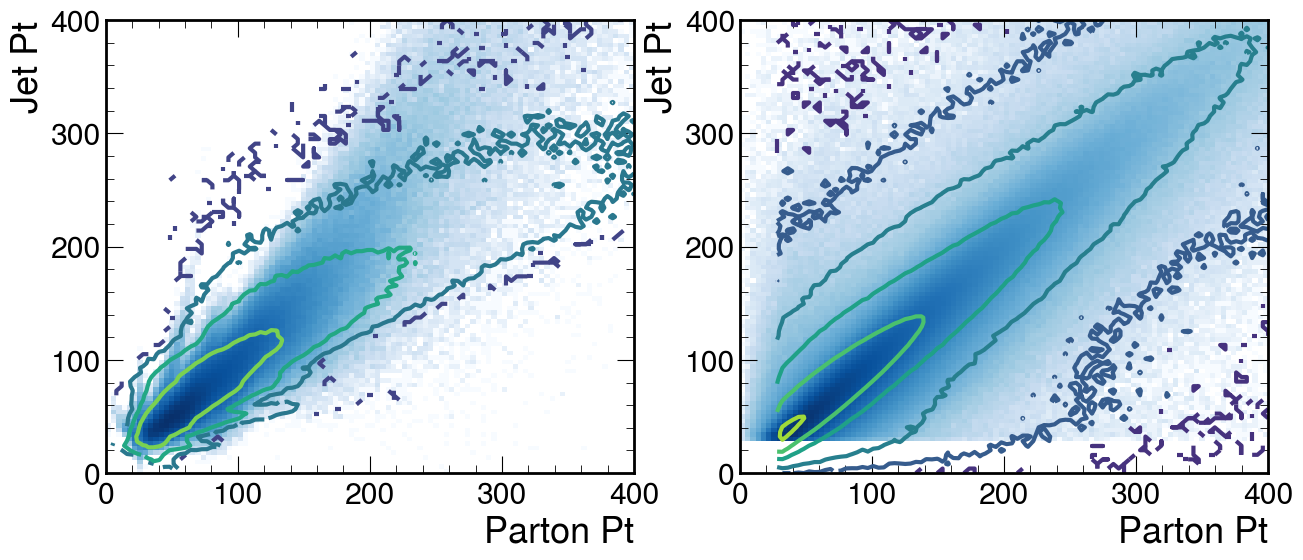

In [126]:
fig,( ax,ay) = plt.subplots(1, 2, figsize=(15, 6), dpi=100)

samples = flow.sample(1000000).detach().numpy()

count, ybins,xbins, im = ax.hist2d(samples[:,0],samples[:,1], bins=100, range=((0,400),(0, 400) ), norm=LogNorm(),cmap="Blues")
ax.set_ylabel("Jet Pt")
ax.set_xlabel("Parton Pt")
ax.contour(count, extent=[xbins.min(),xbins.max(),ybins.min(),ybins.max()],linewidths=3, norm=LogNorm())


count, ybins,xbins, im = ay.hist2d(inputs_pts[:,0],inputs_pts[:,1], bins=100, range=((0,400),(0, 400) ), norm=LogNorm(),cmap="Blues")
ay.set_ylabel("Jet Pt")
ay.set_xlabel("Parton Pt")
ay.contour(count, extent=[xbins.min(),xbins.max(),ybins.min(),ybins.max()],linewidths=3, norm=LogNorm())


In [57]:
samples

array([[ 58.82751 ,  53.799824],
       [ 61.864452,  51.07894 ],
       [152.68604 , 126.14025 ],
       ...,
       [ 99.90926 , 117.23747 ],
       [137.21477 , 139.95152 ],
       [135.51067 , 120.13834 ]], dtype=float32)